In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from tensorflow.keras.layers import Conv1D, Flatten, Reshape, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [3]:
names = ["NaN", "user_id", "activity", "timestamp", "x_axis", "y_axis", "z_axis"]
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/WISDM.csv", header=None, names=names, skiprows=1)

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

df = data.drop('NaN', axis=1)
df["z_axis"].replace(regex = True, inplace = True, to_replace = r';', value = r'')
    # ... and then this column must be transformed to float explicitly
df.dropna(axis=0, how='any', inplace=True)
df.head()
print(df.shape)

(1098203, 6)


In [4]:
df.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098203 entries, 0 to 1098202
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user_id    1098203 non-null  int64  
 1   activity   1098203 non-null  object 
 2   timestamp  1098203 non-null  int64  
 3   x_axis     1098203 non-null  float64
 4   y_axis     1098203 non-null  float64
 5   z_axis     1098203 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 50.3+ MB


In [7]:
df = df[~df['activity'].str.contains('Jogging|Sitting|Upstairs|Downstairs')]

In [8]:
mapping = {'Walking': 0, 'Standing': 1}

# 레이블 인코딩
df['ActivityEncoded'] = df['activity'].map(mapping)
df

,user_id,activity,timestamp,x_axis,y_axis,z_axis,ActivityEncoded
597,33,Walking,49394992294000,0.844462,8.008764,2.792171,0
598,33,Walking,49395102310000,1.116869,8.621680,3.786457,0
599,33,Walking,49395202316000,-0.503953,16.657684,1.307553,0
600,33,Walking,49395302292000,4.794363,10.760075,-1.184970,0
601,33,Walking,49395412338000,-0.040861,9.234595,-0.694638,0
...,...,...,...,...,...,...,...
1095664,19,Standing,131477821443000,-4.990000,8.390000,-0.380000,1
1095665,19,Standing,131477861513000,-5.130000,8.240000,-0.420000,1
1095666,19,Standing,131477941499000,-4.560000,8.500000,-0.890000,1
1095667,19,Standing,131477981508000,-4.480000,8.540000,-1.080000,1


<Axes: xlabel='activity', ylabel='count'>

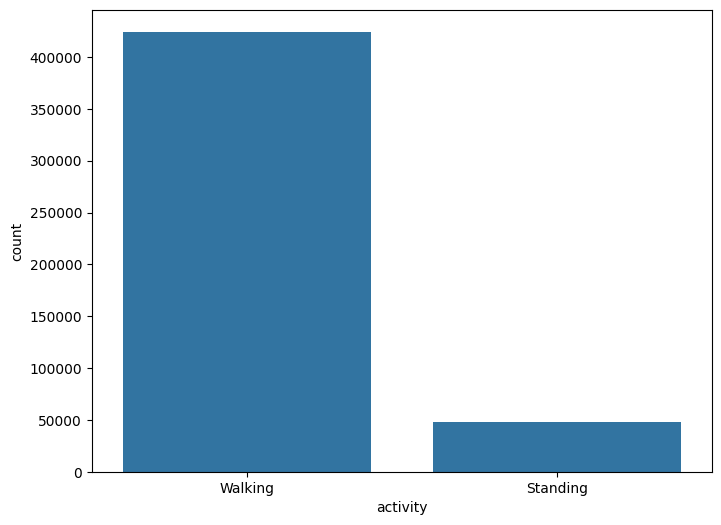

In [9]:
plt.figure(figsize=(8, 6))
sns.countplot(x = "activity", data = df, order = df.activity.value_counts().index)

In [10]:
df.activity.value_counts()

Walking     424397
Standing     48395
Name: activity, dtype: int64

In [11]:
from sklearn.utils import resample

# 'Standing' 행과 'Walking' 행의 개수 확인
standing_count = (df['activity'] == 'Standing').sum()
walking_count = (df['activity'] == 'Walking').sum()

# 'Walking' 행을 언더샘플링하여 개수를 'Standing' 행과 맞추기
walking_data = df[df['activity'] == 'Walking']
walking_data_resampled = resample(walking_data, replace=False, n_samples=standing_count, random_state=42)

# 'Standing' 행과 언더샘플링된 'Walking' 행을 합치기
df = pd.concat([df[df['activity'] == 'Standing'], walking_data_resampled])

# 결과 확인
print(df['activity'].value_counts())

Standing    48395
Walking     48395
Name: activity, dtype: int64


<ipython-input-12-246fd3e84525>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = "user_id", data = df, palette = [sns.color_palette()[0]],
<ipython-input-12-246fd3e84525>:2: UserWarning: 
The palette list has fewer values (1) than needed (36) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x = "user_id", data = df, palette = [sns.color_palette()[0]],


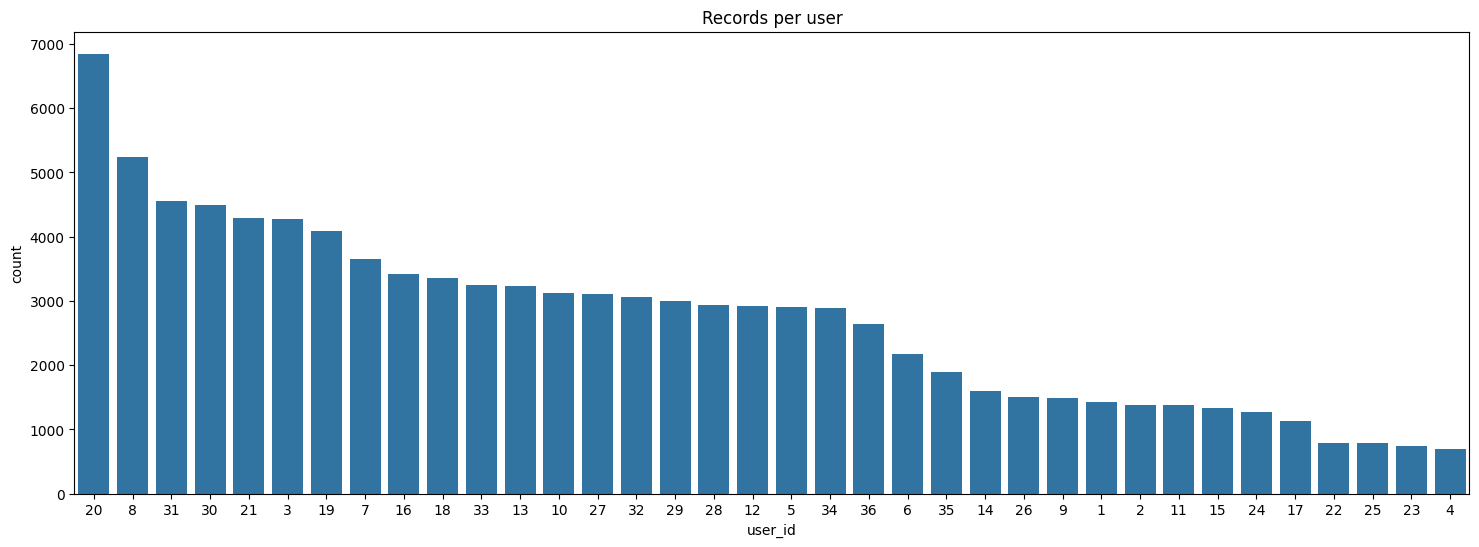

In [12]:
plt.figure(figsize=(18, 6))
sns.countplot(x = "user_id", data = df, palette = [sns.color_palette()[0]],
              order = df.user_id.value_counts().index)
plt.title("Records per user");

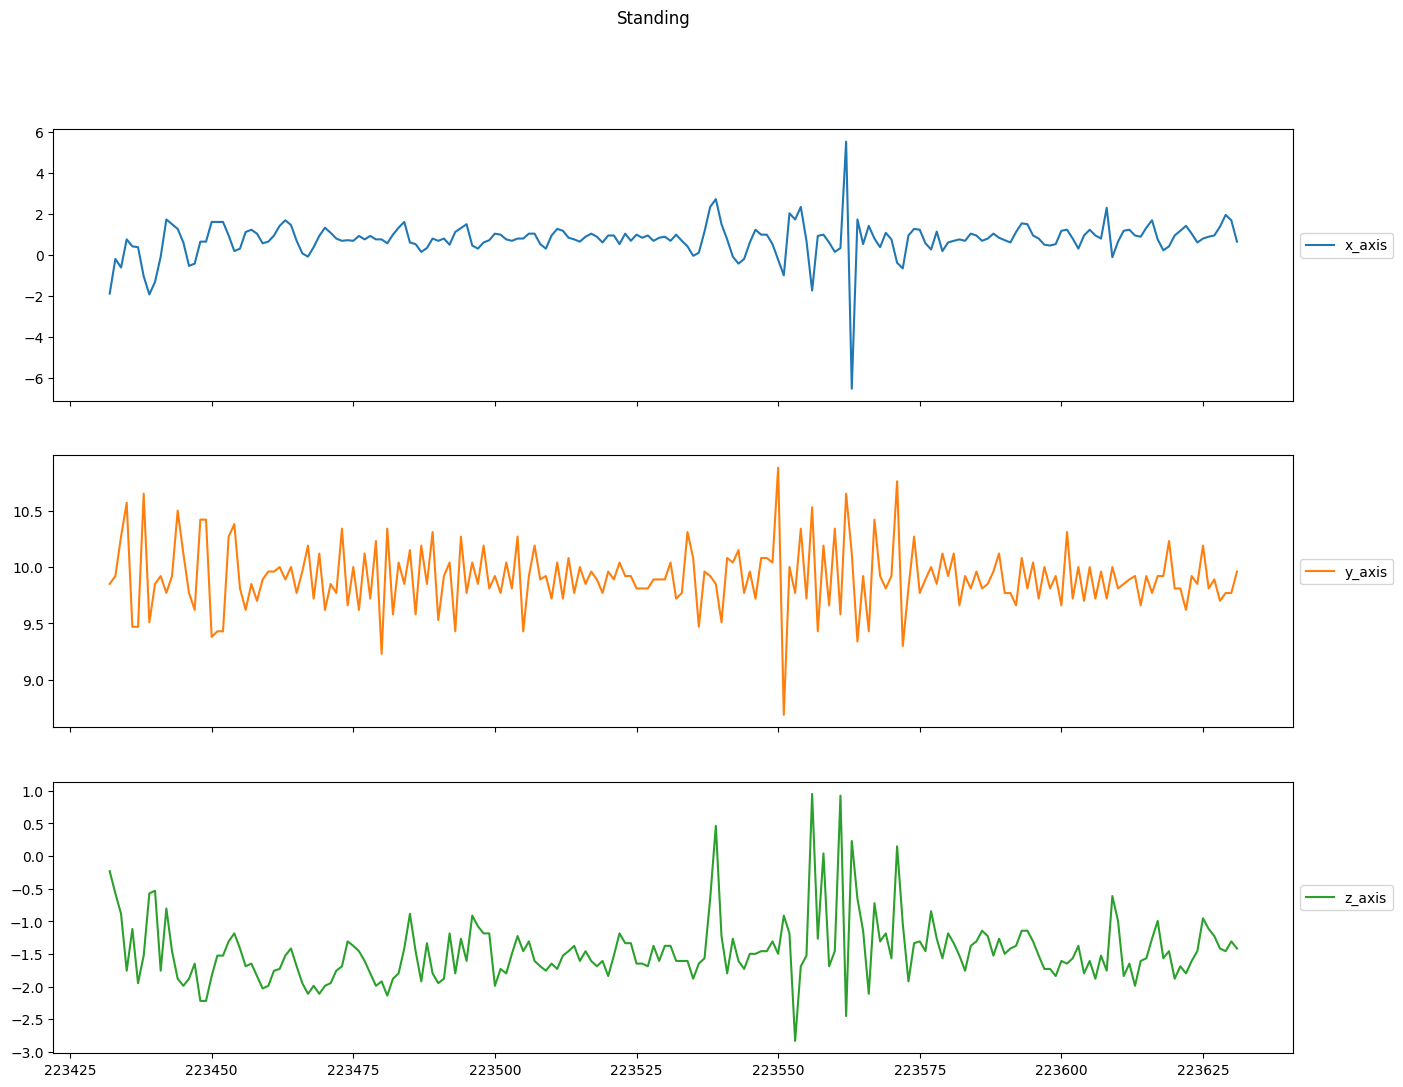

In [13]:
def plot_activity(activity, df):
    data = df[df["activity"] == activity][["x_axis", "y_axis", "z_axis"]][:200]
    axis = data.plot(subplots = True, figsize = (16, 12), title = activity)
    for ax in axis:
        ax.legend(loc = "lower left", bbox_to_anchor = (1.0, 0.5))

plot_activity("Standing", df)

In [14]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 200
STEP = 40

X_data, y_data = create_dataset(df[["x_axis", "y_axis", "z_axis"]], df.ActivityEncoded, TIME_STEPS,
                                  STEP)

X_train, X_test,y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, stratify=  y_data )
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify=  y_train )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1545, 200, 3) (1545, 1)
(483, 200, 3) (483, 1)


In [15]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown = "ignore", sparse_output = False)
enc = enc.fit(y_train)

y_train_hot = enc.transform(y_train)
y_test_hot = enc.transform(y_test)
y_val_hot = enc.transform(y_val)

print(X_train.shape, y_train_hot.shape, X_test.shape, y_test_hot.shape)

(1545, 200, 3) (1545, 2) (483, 200, 3) (483, 2)


In [17]:
#Epoch 10

BATCH_SIZE = 32

verbose,epochs,batch_size=1,10, BATCH_SIZE

n_timesteps,n_features,n_outputs= X_train.shape[1],X_train.shape[2],y_train_hot.shape[1]
n_timesteps,n_features,n_outputs

(200, 3, 2)

<h1> CNN 1 </h1>

In [18]:
# Model 1
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 198, 64)           640       
                                                                 
 dropout (Dropout)           (None, 198, 64)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 99, 64)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 6336)              0         
                                                                 
 dense (Dense)               (None, 128)               811136    
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                        

In [19]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
13/13 [==============================] - 5s 144ms/step - loss: 5.7710 - accuracy: 0.6874 - val_loss: 0.2050 - val_accuracy: 0.9070
Epoch 2/10
13/13 [==============================] - 2s 118ms/step - loss: 0.3303 - accuracy: 0.9178 - val_loss: 0.1296 - val_accuracy: 0.9638
Epoch 3/10
13/13 [==============================] - 2s 132ms/step - loss: 0.1177 - accuracy: 0.9722 - val_loss: 0.0085 - val_accuracy: 0.9948
Epoch 4/10
13/13 [==============================] - 2s 152ms/step - loss: 0.0049 - accuracy: 0.9981 - val_loss: 3.0203e-04 - val_accuracy: 1.0000
Epoch 5/10
13/13 [==============================] - 2s 155ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 2.2054e-04 - val_accuracy: 1.0000
Epoch 6/10
13/13 [==============================] - 2s 119ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 2.1730e-04 - val_accuracy: 1.0000
Epoch 7/10
13/13 [==============================] - 2s 171ms/step - loss: 7.4642e-04 - accuracy: 1.0000 - val_loss: 2.4074e-04 - val_acc

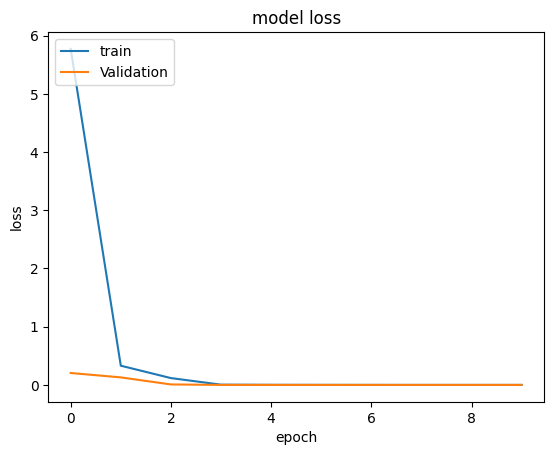

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

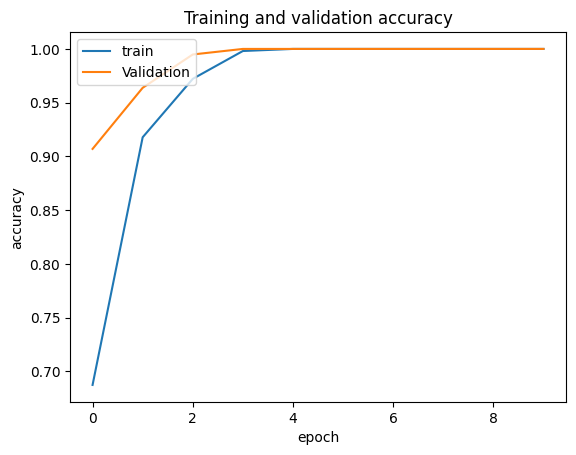

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

16/16 [==============================] - 0s 8ms/step
f1_score =  1.0
1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       241
           1       1.00      1.00      1.00       242

    accuracy                           1.00       483
   macro avg       1.00      1.00      1.00       483
weighted avg       1.00      1.00      1.00       483



<Axes: >

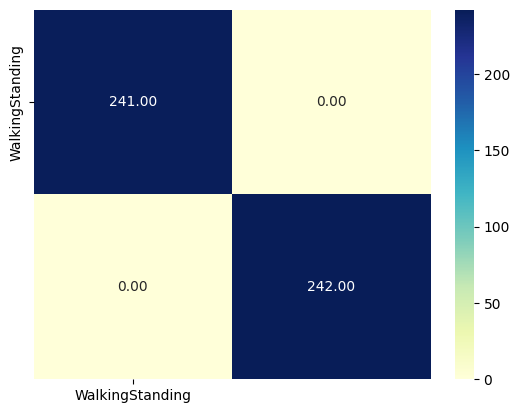

In [22]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking''Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1> CNN 2 </h1>

In [23]:
# Model 2
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 198, 64)           640       
                                                                 
 dropout_1 (Dropout)         (None, 198, 64)           0         
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 99, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 97, 64)            12352     
                                                                 
 dropout_2 (Dropout)         (None, 97, 64)            0         
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 48, 64)            0         
 g1D)                                                 

In [24]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)

Epoch 1/10
13/13 [==============================] - 6s 185ms/step - loss: 2.8861 - accuracy: 0.5955 - val_loss: 0.3508 - val_accuracy: 0.9897
Epoch 2/10
13/13 [==============================] - 2s 133ms/step - loss: 0.2591 - accuracy: 0.9113 - val_loss: 0.2112 - val_accuracy: 0.9897
Epoch 3/10
13/13 [==============================] - 2s 130ms/step - loss: 0.0669 - accuracy: 0.9812 - val_loss: 0.1540 - val_accuracy: 1.0000
Epoch 4/10
13/13 [==============================] - 2s 135ms/step - loss: 0.0175 - accuracy: 0.9942 - val_loss: 0.0492 - val_accuracy: 1.0000
Epoch 5/10
13/13 [==============================] - 2s 123ms/step - loss: 0.0061 - accuracy: 0.9994 - val_loss: 0.0359 - val_accuracy: 1.0000
Epoch 6/10
13/13 [==============================] - 2s 188ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0284 - val_accuracy: 1.0000
Epoch 7/10
13/13 [==============================] - 4s 278ms/step - loss: 9.1468e-04 - accuracy: 1.0000 - val_loss: 0.0233 - val_accuracy: 1.0000
Ep

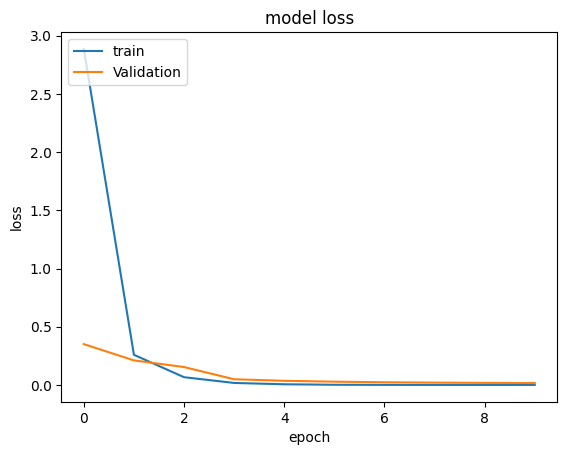

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

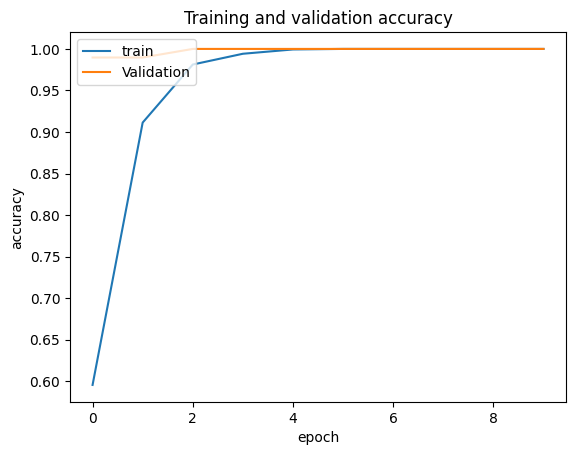

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

16/16 [==============================] - 0s 9ms/step
f1_score =  0.9979296066252588
0.9979296066252588
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       241
           1       1.00      1.00      1.00       242

    accuracy                           1.00       483
   macro avg       1.00      1.00      1.00       483
weighted avg       1.00      1.00      1.00       483



<Axes: >

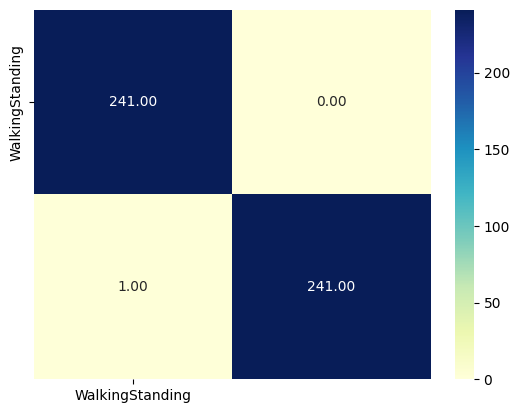

In [27]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking''Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1> CNN 3 </h1>

In [28]:
# Model 3
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 198, 64)           640       
                                                                 
 dropout_3 (Dropout)         (None, 198, 64)           0         
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 99, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_4 (Conv1D)           (None, 97, 64)            12352     
                                                                 
 dropout_4 (Dropout)         (None, 97, 64)            0         
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 48, 64)            0         
 g1D)                                                 

In [29]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)

Epoch 1/10
13/13 [==============================] - 9s 289ms/step - loss: 2.6383 - accuracy: 0.6142 - val_loss: 0.4128 - val_accuracy: 0.7209
Epoch 2/10
13/13 [==============================] - 2s 172ms/step - loss: 0.2366 - accuracy: 0.9139 - val_loss: 0.2418 - val_accuracy: 0.9922
Epoch 3/10
13/13 [==============================] - 2s 131ms/step - loss: 0.0703 - accuracy: 0.9812 - val_loss: 0.1002 - val_accuracy: 0.9948
Epoch 4/10
13/13 [==============================] - 2s 164ms/step - loss: 0.0345 - accuracy: 0.9838 - val_loss: 0.0798 - val_accuracy: 1.0000
Epoch 5/10
13/13 [==============================] - 3s 239ms/step - loss: 0.0143 - accuracy: 0.9948 - val_loss: 0.0564 - val_accuracy: 1.0000
Epoch 6/10
13/13 [==============================] - 2s 177ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.0322 - val_accuracy: 1.0000
Epoch 7/10
13/13 [==============================] - 2s 176ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0223 - val_accuracy: 1.0000
Epoch 

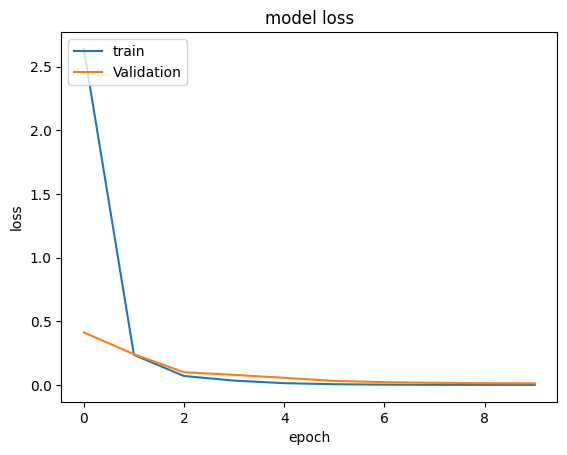

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

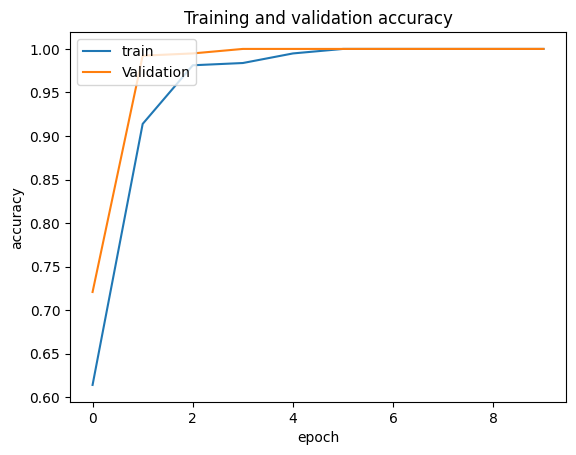

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

16/16 [==============================] - 0s 6ms/step
f1_score =  0.9979296066252588
0.9979296066252588
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       241
           1       1.00      1.00      1.00       242

    accuracy                           1.00       483
   macro avg       1.00      1.00      1.00       483
weighted avg       1.00      1.00      1.00       483



<Axes: >

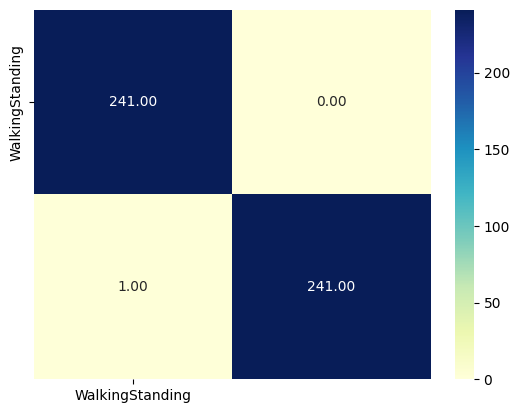

In [32]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking''Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')